In [1]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
from tqdm import tqdm
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr
import torch.nn.functional as F


In [2]:
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

In [3]:
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

In [4]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

In [5]:
class EEGAutoencoder(nn.Module):
    def __init__(self, input_dim=320*64, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def cluster_with_autoencoder(eeg_data, k=5, latent_dim=32, epochs=50, device='cpu'):
    

    N, T, C = eeg_data.shape
    data_flat = eeg_data.reshape(N, T * C)
    data_tensor = data_flat.clone().detach().float()
    loader = DataLoader(TensorDataset(data_tensor), batch_size=64, shuffle=True)

    model = EEGAutoencoder(input_dim=T*C, latent_dim=latent_dim).to('cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # Train autoencoder
    model.train()
    print("Training Autoencoder...")

    for epoch in range(epochs):
        epoch_loss = 0.0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch, in pbar:
            batch = batch.to('cpu')
            recon, _ = model(batch)
            loss = loss_fn(recon, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Get latent features
    model.eval()
    with torch.no_grad():
        latent_all = model.encoder(data_tensor.to('cpu')).cpu().numpy()

    # KMeans on latent space
    kmeans = KMeans(n_clusters=k, random_state=0).fit(latent_all)
    labels = kmeans.labels_

    return labels, latent_all, model, kmeans

In [7]:
k = 5
device = 'cpu' if torch.cpu.is_available() else 'cpu'

cluster_labels, latent_embeddings, cluster_model, kmeans = cluster_with_autoencoder(X_train, k=k, latent_dim=32, epochs=1, device=device)

Training Autoencoder...


Epoch 1/1: 100%|██████████████████████████████████████████████████████| 1428/1428 [02:10<00:00, 10.94it/s, Loss=26.3506]


In [8]:
clustered_eeg = [X_train[cluster_labels == i] for i in range(k)]

In [9]:
for i in range(k):
    print(clustered_eeg[i].shape) 

torch.Size([88734, 320, 64])
torch.Size([757, 320, 64])
torch.Size([120, 320, 64])
torch.Size([1769, 320, 64])
torch.Size([1, 320, 64])


In [10]:
clustered_y = [y_train[cluster_labels == i] for i in range(k)]

In [11]:
for i in range(k):
    print(clustered_y[i].shape) 

torch.Size([88734, 320])
torch.Size([757, 320])
torch.Size([120, 320])
torch.Size([1769, 320])
torch.Size([1, 320])


In [12]:
X_val_flat = X_val.view(X_val.shape[0], -1).to('cpu')   # shape: (N_val, 320*64)
X_test_flat = X_test.view(X_test.shape[0], -1).to('cpu')


cluster_model.eval()
with torch.no_grad():
    latent_val = cluster_model.encoder(X_val_flat).cpu().numpy()   # shape: (N_val, latent_dim)
    latent_test = cluster_model.encoder(X_test_flat).cpu().numpy() # shape: (N_test, latent_dim)

    
val_cluster_labels = kmeans.predict(latent_val)
test_cluster_labels = kmeans.predict(latent_test)


clustered_val_eeg = [X_val[val_cluster_labels == i] for i in range(k)]
clustered_val_y   = [y_val[val_cluster_labels == i] for i in range(k)]

clustered_test_eeg = [X_test[test_cluster_labels == i] for i in range(k)]
clustered_test_y   = [y_test[test_cluster_labels == i] for i in range(k)]

In [13]:
def pearson_corr(pred, target):
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    correlations = [pearsonr(p, t)[0] for p, t in zip(pred, target)]
    return sum(correlations) / len(correlations)

def cosine_sim(pred, target):
    return F.cosine_similarity(pred, target, dim=1).mean().item()

In [14]:
class LSTMExpert(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=64, num_layers=1, output_dim=320):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):  # x: (B, 320, 64)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # use last time step hidden state
        return out  # (B, 320)

In [15]:
experts = [LSTMExpert().to('cpu') for _ in range(k)]

In [19]:
epochs = 1

In [21]:
for i in range(k):
    train_loader = DataLoader(TensorDataset(clustered_eeg[i], clustered_y[i]), batch_size=256, shuffle=True)
    model = experts[i]
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        loop = tqdm(train_loader, desc=f"Expert {i+1}/{k} | Epoch {epoch+1}/{epochs}")
        for x, y in loop:
            x, y = x.to('cpu'), y.to('cpu')
            pred = model(x)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar with current loss
            loop.set_postfix(loss=loss.item())

Expert 1/5 | Epoch 1/1: 100%|█████████████████████████████████████████████| 347/347 [02:43<00:00,  2.12it/s, loss=0.245]
Expert 2/5 | Epoch 1/1: 100%|█████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s, loss=0.632]
Expert 3/5 | Epoch 1/1: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s, loss=0.702]
Expert 4/5 | Epoch 1/1: 100%|█████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.60it/s, loss=0.682]
Expert 5/5 | Epoch 1/1: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.87it/s, loss=0.56]


In [22]:
class CombinedModel(nn.Module):
    def __init__(self, experts, combine_dim=320, output_dim=320):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.combine_layer = nn.Sequential(
            nn.Conv1d(k, 16, kernel_size=3, padding=1),  # k experts’ outputs as channels
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=1),
        )
    
    def forward(self, x):  # x: (B, 320, 64)
        expert_outputs = [expert(x) for expert in self.experts]  # list of (B, 320)
        expert_stack = torch.stack(expert_outputs, dim=1)  # (B, k, 320)

        # Move expert_stack and combine_layer to CPU
        expert_stack_cpu = expert_stack.cpu()
        combine_layer_cpu = self.combine_layer.to('cpu')

        out = combine_layer_cpu(expert_stack_cpu)  # Run combine_layer on CPU
        return out.squeeze(1).to(x.device)  # Move output back to GPU

In [23]:
X_all = torch.cat(clustered_eeg, dim=0)
y_all = torch.cat(clustered_y, dim=0)
train_loader = DataLoader(TensorDataset(X_all, y_all), batch_size=32, shuffle=True)

combiner_model = CombinedModel(experts).to('cpu')
optimizer = torch.optim.Adam(combiner_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

print("Training Combiner Model...")
for epoch in range(epochs):
    # Training Phase
    combiner_model.train()
    for expert in experts:
        expert.train()
    
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for x, y in pbar:
        x, y = x.to('cpu'), y.to('cpu')
        pred = combiner_model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    avg_train_loss = epoch_loss / len(train_loader)
    combiner_model.combine_layer = combiner_model.combine_layer.to('cpu')
    # Validation Phase with cluster-specific experts
    combiner_model.eval()
    for expert in experts:
        expert.eval()

    val_preds = []
    val_targets = []

    with torch.no_grad():
        for i in range(len(X_val)):
            x = X_val[i].unsqueeze(0).to('cpu')  # (1, 320, 64)
            y = y_val[i].unsqueeze(0).to('cpu')  # (1, 320)
            cluster_id = val_cluster_labels[i]

            expert_output = experts[cluster_id](x)  # (1, 320)

            # Fill other expert outputs with zeros
            dummy_outputs = [torch.zeros_like(expert_output) for _ in range(len(experts))]
            dummy_outputs[cluster_id] = expert_output
            expert_stack = torch.stack(dummy_outputs, dim=1).to('cpu')  # <-- Add .to('cpu')
#             print("expert_stack device:", expert_stack.device)
#             print("combine_layer weights device:", next(combiner_model.combine_layer.parameters()).device)
            pred = combiner_model.combine_layer(expert_stack).squeeze(1)

            val_preds.append(pred)
            val_targets.append(y)

    val_preds = torch.cat(val_preds, dim=0)       # (N_val, 320)
    val_targets = torch.cat(val_targets, dim=0)   # (N_val, 320)

    val_mse = F.mse_loss(val_preds, val_targets).item()
    val_pearson = pearson_corr(val_preds, val_targets)
    val_cosine = cosine_sim(val_preds, val_targets)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | "
          f"Val MSE = {val_mse:.4f} | Pearson = {val_pearson:.4f} | Cosine = {val_cosine:.4f}")

Training Combiner Model...


Epoch 1/1: 100%|███████████████████████████████████████████████████████| 2856/2856 [18:07<00:00,  2.63it/s, Loss=0.1953]


expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: cpu
expert_stack device: cpu
combine_layer weights device: c

Epoch 1: Train Loss = 0.2402 | Val MSE = 0.2653 | Pearson = 0.0059 | Cosine = 0.8039


In [25]:
combiner_model.eval()
for expert in experts:
    expert.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for i in range(len(X_test)):
        x = X_test[i].unsqueeze(0).to('cpu')  # (1, 320, 64)
        y = y_test[i].unsqueeze(0).to('cpu')  # (1, 320)
        cluster_id = test_cluster_labels[i]

        expert_output = experts[cluster_id](x)  # (1, 320)

        # Fill other expert outputs with zeros
        dummy_outputs = [torch.zeros_like(expert_output) for _ in range(len(experts))]
        dummy_outputs[cluster_id] = expert_output
        expert_stack = torch.stack(dummy_outputs, dim=1).to('cpu')  
        pred = combiner_model.combine_layer(expert_stack).squeeze(1)

        test_preds.append(pred)
        test_targets.append(y)



TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim = 0, *, Tensor out = None)
 * (tuple of Tensors tensors, name dim, *, Tensor out = None)


In [26]:
test_preds = torch.cat(test_preds, dim=0)       
test_targets = torch.cat(test_targets, dim=0)   

test_mse = F.mse_loss(test_preds, test_targets).item()
test_pearson = pearson_corr(test_preds, test_targets)
test_cosine = cosine_sim(test_preds, test_targets)

In [27]:
print(f"Val MSE = {test_mse:.4f} | Pearson = {test_pearson:.4f} | Cosine = {test_cosine:.4f}")

Val MSE = 0.2345 | Pearson = 0.0067 | Cosine = 0.7980


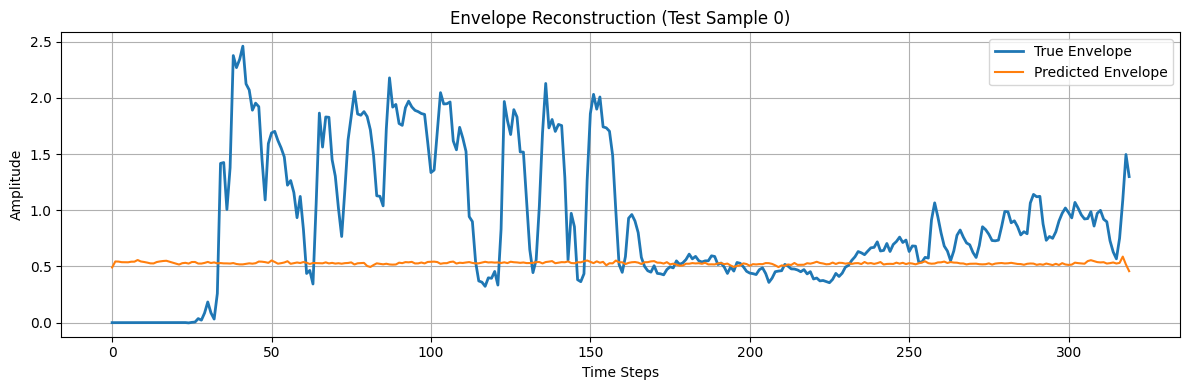

In [32]:
import matplotlib.pyplot as plt

# Choose a test index to visualize
test_index = 0  # Change this to visualize different samples

# Get predicted and true envelope
pred_envelope = test_preds[test_index].cpu().numpy()
true_envelope = test_targets[test_index].cpu().numpy()

# Plot
plt.figure(figsize=(12, 4))
plt.plot(true_envelope, label='True Envelope', linewidth=2)
plt.plot(pred_envelope, label='Predicted Envelope')
plt.title(f"Envelope Reconstruction (Test Sample {test_index})")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

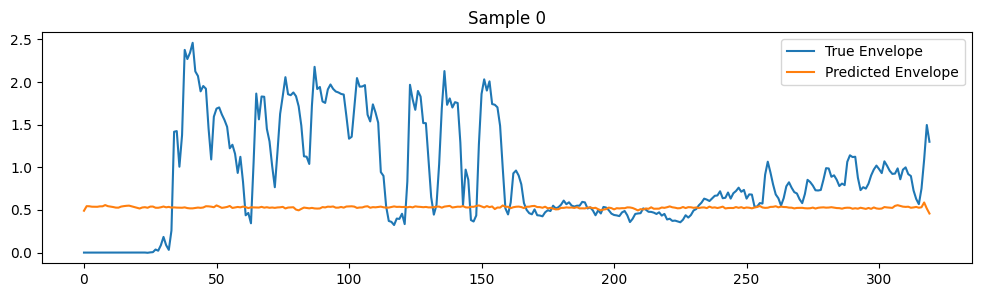

In [31]:
for i in range(1):  # plot first 3 test samples
    pred = test_preds[i].cpu().numpy()
    true = test_targets[i].cpu().numpy()
    plt.figure(figsize=(12, 3))
    plt.plot(true, label="True Envelope")
    plt.plot(pred, label="Predicted Envelope")
    plt.title(f"Sample {i}")
    plt.legend()
    plt.show()